In [1]:
import sys
sys.path.append("..")

import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from cmcrameri import cm
from PIL import Image
from huggingface_hub import hf_hub_download, login
from torchvision import transforms
import torch

from src.mopadi.configs.templates import texture100k_autoenc
from src.mopadi.configs.templates_cls import default_linear_clf
from src.mopadi.linear_clf.manipulate.manipulate_linear_cls import ImageManipulator, compute_structural_similarity

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.chdir("..")

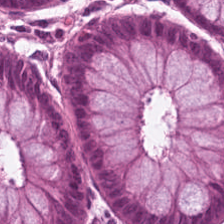

In [2]:
filename = "CRC-VAL-HE-7K-NORM-TCGA-YLVCMEHK.tif"
img = Image.open(f"images/example_data/{filename}").convert('RGB')
img

In [3]:
# for downloading pretrained MoPadi models authenticate with a Hugging Face API token
#token = input("Enter your Hugging Face API token: ")
#login(token=token)

# or set your Hugging Face token as an environment variable by running `export HF_TOKEN="your_token_here`
#token = os.getenv("HF_TOKEN")
#login(token=token)

In [4]:
# download model files
# you need to have obtained access to the MoPadi repository on Hugging Face: https://huggingface.co/KatherLab/MoPaDi
autoenc_model_path = hf_hub_download(
    repo_id="KatherLab/MoPaDi",
    filename="tissue_classes_model/autoenc.ckpt",
)
print(f"Autoencoder's checkpoint downloaded to: {autoenc_model_path}")

clf_model_path = hf_hub_download(
    repo_id="KatherLab/MoPaDi",
    filename="tissue_classes_model/classifier.ckpt",
)
print(f"Classifier's checkpoint downloaded to: {clf_model_path}")

features_path = hf_hub_download(
    repo_id="KatherLab/MoPaDi",
    filename="tissue_classes_model/features.pkl",
)
print(f"Features downloaded to: {features_path}")

Autoencoder's checkpoint downloaded to: /home/laura/.cache/huggingface/hub/models--KatherLab--MoPaDi/snapshots/5d8e775e24473c5d8f4c0c57fd5c865c3c2a4aab/tissue_classes_model/autoenc.ckpt
Classifier's checkpoint downloaded to: /home/laura/.cache/huggingface/hub/models--KatherLab--MoPaDi/snapshots/5d8e775e24473c5d8f4c0c57fd5c865c3c2a4aab/tissue_classes_model/classifier.ckpt
Features downloaded to: /home/laura/.cache/huggingface/hub/models--KatherLab--MoPaDi/snapshots/5d8e775e24473c5d8f4c0c57fd5c865c3c2a4aab/tissue_classes_model/features.pkl


In [5]:
conf = {
    "data": {},
    "linear_classifier": {
        "classes": [
            'ADI',
            'BACK',
            'DEB',
            'LYM',
            'MUC',
            'MUS',
            'NORM',
            'STR',
            'TUM'
        ],
        "use_pretrained_clf": True,
        "pretrained_autoenc_name": "texture_model",
        "feats_infer_path": features_path,
    },
}
config = default_linear_clf(conf)

Using default 'Texture (NCT100k)' model.


In [6]:
image_manipulator = ImageManipulator(
    autoenc_config=texture100k_autoenc(),
    autoenc_path=autoenc_model_path,
    cls_path=clf_model_path,
    cls_config=config,
)

Seed set to 0
Seed set to 0


Loading pre-extracted features of the encoder...
Classes: ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
latent step: 9375
Both models loaded successfully.
Valid target classes: ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']


In [7]:
res = []
lvls = [0.2, 0.4, 0.6, 0.8, 1.0]

for i in tqdm(lvls, desc="Manipulating images..."):
    res.append(image_manipulator.manipulate_image(
        img=img,
        target_class="TUM",
        manipulation_amplitude=i,
        save_path="images/example_norm_to_tumor",
        save_fname_ori=filename.split(".")[0] + "_original.png",
    ))

Manipulating images...: 100%|██████████| 5/5 [07:53<00:00, 94.68s/it] 


### Metrics

In [9]:
sim = []
sim.append(compute_structural_similarity(res[0]["ori_img"].squeeze(), res[0]["ori_img"].squeeze()))

for i in range(len(res)):
   sim.append(compute_structural_similarity(res[i]["manip_img_rgb"], res[0]["ori_img"].squeeze()))

### Results

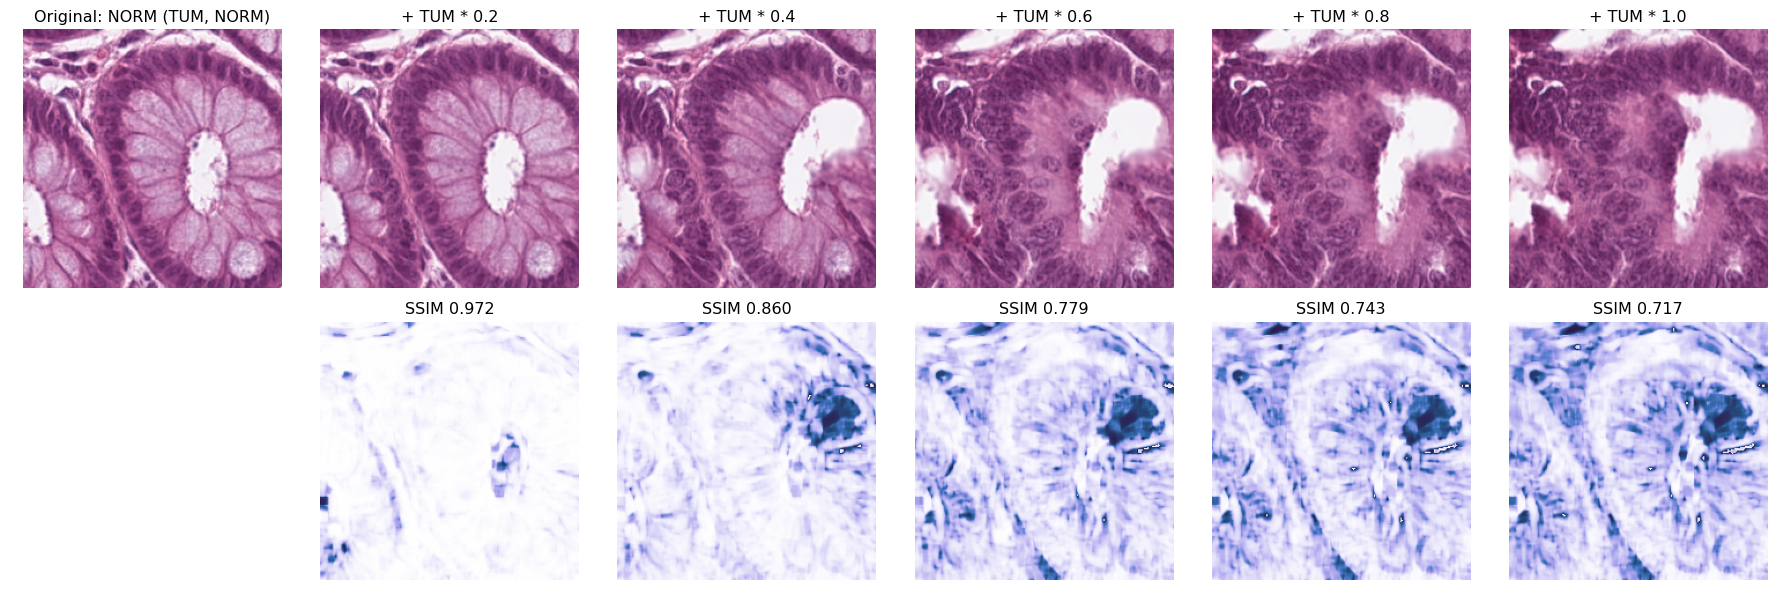

In [10]:
num_rows=2
num_cols=6

img_height, img_width = (300, 300)
dpi = 96 # Display resolution (dots per inch)
fig_width = (img_width * num_cols) / dpi
fig_height = (img_height * num_rows) / dpi

fig, ax = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), dpi=dpi)

ori = res[0]["ori_img"]
ax[0,0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[0,0].axis('off')
ax[0,0].set_title(f'Original: NORM (TUM, NORM)')
ax[1,0].axis('off')

for i in range(len(res[:6])):

    ax[0,i+1].imshow(res[i]["manip_img"].permute(1, 2, 0).cpu())
    ax[0,i+1].set_title(f"+ TUM * {str(lvls[i])}")
    ax[0,i+1].axis('off')

    ssim_image_rotated = np.rot90(sim[i+1][0], k=-1)
    flipped_ssim = np.fliplr(ssim_image_rotated)
    ax[1,i+1].imshow(flipped_ssim, cmap=cm.devon)
    ax[1,i+1].set_title("SSIM {sim:.3f}".format(sim = sim[i+1][1]))
    ax[1,i+1].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.12)
plt.savefig(os.path.join("images/example_norm_to_tumor", "all_ssim.png"), bbox_inches='tight')
plt.tight_layout()

In [11]:
print(f"Targets: {res[0]['target_list']}")

with torch.no_grad():
    image_manipulator.classifier.ema_classifier.eval()

    latent_norm = image_manipulator.classifier.normalize(res[0]['ori_feats'])
    output = image_manipulator.classifier.ema_classifier.forward(latent_norm)                
    pred = torch.sigmoid(output)#, dim=1)
    _, max_index = torch.max(pred, 1)
    predicted_class = res[0]['target_list'][max_index.item()]
    print("Predictions for the original image:")
    print(res[0]['target_list'])
    print(f"{[f'{p:.3f}' for p in pred.cpu().numpy().flatten()]}")
    print(f"Predicted class: {predicted_class}")
    print('________________')

for i in range(len(res[:6])):
    print(f"Image manipulated at {lvls[i]}")
    print(res[i]['preds'])
    print(f"Predicted class: {res[i]['pred_class']}")

Targets: ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']


Predictions for the original image:
['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
['0.025', '0.010', '0.084', '0.031', '0.189', '0.155', '0.561', '0.056', '0.158']
Predicted class: NORM
________________
Image manipulated at 0.2
['0.016', '0.004', '0.019', '0.033', '0.151', '0.119', '0.516', '0.008', '0.135']
Predicted class: NORM
Image manipulated at 0.4
['0.015', '0.003', '0.014', '0.027', '0.120', '0.092', '0.236', '0.004', '0.489']
Predicted class: TUM
Image manipulated at 0.6
['0.005', '0.001', '0.005', '0.015', '0.034', '0.027', '0.030', '0.001', '0.881']
Predicted class: TUM
Image manipulated at 0.8
['0.004', '0.001', '0.004', '0.010', '0.024', '0.038', '0.030', '0.001', '0.887']
Predicted class: TUM
Image manipulated at 1.0
['0.004', '0.001', '0.003', '0.006', '0.016', '0.055', '0.023', '0.001', '0.891']
Predicted class: TUM
